In [192]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [193]:
T = 4   # Longueur des séquences
D = 50         # Dimension des vecteurs X^t
N = 10000  

In [194]:
k = 3
V = np.random.randint(0, 2, size=(k, T)) 

In [195]:
B = V.T@V

In [196]:
B

array([[1, 1, 0, 0],
       [1, 2, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 1]])

In [197]:
def factorise(B, tol=1e-8):
    # Vérification symétrie
    if not np.allclose(B, B.T, atol=tol):
        raise ValueError("La matrice B n'est pas symétrique.")

    # Décomposition spectrale
    eigvals, eigvecs = np.linalg.eigh(B)

    # Vérification semi-définie positive
    if np.any(eigvals < -tol):
        raise ValueError("La matrice B n'est pas semi-définie positive.")

    # Construction de C = U Λ^{1/2}
    sqrt_eigvals = np.sqrt(np.clip(eigvals, 0, None))
    C = eigvecs @ np.diag(sqrt_eigvals)

    return C

In [198]:

def generate_X(C, N, D):
    T = C.shape[0]
    Z = np.random.randn(N, D, T)  # Z ~ N(0, I)
    X = np.einsum('ndt,ts->nds', Z, C.T)  # équivalent à batch matmul Z @ C.T
    return X

In [199]:
C = factorise(B)
X_samples = generate_X(C, N=1000, D=10)

# Estimation de E[X^T X]
B_est = np.mean([X.T @ X for X in X_samples], axis=0) / 10
print(B_est)

[[ 9.91166756e-01  9.86289292e-01 -1.73313043e-03 -4.87746389e-03]
 [ 9.86289292e-01  1.95668354e+00 -6.07245556e-03  9.70394247e-01]
 [-1.73313043e-03 -6.07245556e-03  9.90275836e-01 -4.33932496e-03]
 [-4.87746389e-03  9.70394247e-01 -4.33932496e-03  9.75271711e-01]]


In [200]:
def compute_moments(B, T_max):
    """
    Calcule (B, B^2, ..., B^T_max) et les normalise (norme Frobenius)
    """
    moments = [B]
    for _ in range(1, T_max):
        moments.append(moments[-1] @ B)

    # Normalisation par norme de Frobenius
    normalized = [
        M / (np.linalg.norm(M, ord='fro') + 1e-8) for M in moments
    ]
    return np.stack(normalized, axis=0)  # shape (T_max, T, T)


In [201]:
print(compute_moments(B, T_max=4))

[[[0.30151134 0.30151134 0.         0.        ]
  [0.30151134 0.60302269 0.         0.30151134]
  [0.         0.         0.30151134 0.        ]
  [0.         0.30151134 0.         0.30151134]]

 [[0.21952852 0.32929278 0.         0.10976426]
  [0.32929278 0.65858556 0.         0.32929278]
  [0.         0.         0.10976426 0.        ]
  [0.10976426 0.32929278 0.         0.21952852]]

 [[0.18493168 0.33287702 0.         0.14794534]
  [0.33287702 0.66575405 0.         0.33287702]
  [0.         0.         0.03698634 0.        ]
  [0.14794534 0.33287702 0.         0.18493168]]

 [[0.17281317 0.33328254 0.         0.16046937]
  [0.33328254 0.66656508 0.         0.33328254]
  [0.         0.         0.0123438  0.        ]
  [0.16046937 0.33328254 0.         0.17281317]]]


In [202]:

def generate_dataset(N, D, T):

    B_true = B
    # Factorisation pour générer X
    C = factorise(B_true)
    X_samples = generate_X(C, N, D)

    # Création de (X, y)
    X_data = X_samples
    y_data = np.array([compute_moments(X.T @ X / D, T) for X in X_samples])  # normalisé

    return X_data, y_data

In [203]:
X_data, y_data = generate_dataset(N=1000, D=10, T=4)
B_est_mean = y_data[:, 0].mean(axis=0)  # moment 1 moyen
print("Différence moyenne :")
print(np.round(B_est_mean - B, 3))

Différence moyenne :
[[-7.160e-01 -7.320e-01  2.000e-03 -1.600e-02]
 [-7.320e-01 -1.462e+00  2.000e-03 -7.300e-01]
 [ 2.000e-03  2.000e-03 -6.950e-01  1.000e-03]
 [-1.600e-02 -7.300e-01  1.000e-03 -7.140e-01]]


In [204]:

X, y = generate_dataset(N, D, T)

print("X.shape :", X.shape)  # (N, D, T)
print("y.shape :", y.shape)  # (N, T * T * T)


X.shape : (10000, 50, 4)
y.shape : (10000, 4, 4, 4)


In [205]:
y_B = y[:,0,:,:]
print(y_B.mean(axis=0))

[[ 2.99012779e-01  2.94500532e-01 -3.45226203e-04 -4.51224703e-03]
 [ 2.94500532e-01  5.88428633e-01 -1.62482119e-03  2.93928101e-01]
 [-3.45226203e-04 -1.62482119e-03  3.03247290e-01 -1.27959499e-03]
 [-4.51224703e-03  2.93928101e-01 -1.27959499e-03  2.98440348e-01]]


In [206]:
class MomentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [207]:
X, y = generate_dataset(N, D, T)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = MomentDataset(X_train, y_train)
test_dataset  = MomentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [208]:
class MomentTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, T):
        super().__init__()
        self.T = T

        # Embedding linéaire initial (projeté à d_model)
        self.input_proj = nn.Linear(d_model, d_model)

        # Encodage de position appris
        self.pos_embedding = nn.Parameter(torch.randn(1, T, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Projection vers une matrice T x T pour chaque moment (T moments au total)
        self.output_proj = nn.Linear(d_model, T * T * T)

    def forward(self, x):
        # x: (batch_size, D, T)
        x = x.permute(0, 2, 1)  # -> (batch_size, T, D)
        x = self.input_proj(x)  # -> (batch_size, T, d_model)

        # Ajout du positional embedding
        x = x + self.pos_embedding  # broadcasting sur batch

        # Passage dans le Transformer
        x = self.transformer(x)  # (batch_size, T, d_model)

        # Moyenne globale ou moyenne sur les positions
        x_pooled = x.mean(dim=1)  # (batch_size, d_model)

        # Projection finale
        y_hat = self.output_proj(x_pooled)  # (batch_size, T*T*T)
        y_hat = y_hat.view(-1, self.T, self.T, self.T)  # reshape en tenseur de moments

        return y_hat


In [209]:
model = MomentTransformer(
    d_model=D,     # correspond à la dimension des vecteurs d'entrée
    nhead=2,
    num_layers=2,
    dim_feedforward=32,
    T=T
)


In [210]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [211]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [212]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    train_loss_list = []
    test_loss_list = []
    model.to(device)
    for epoch in range(num_epochs):
        test_loss = evaluate(model, test_loader, device)
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)


        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return train_loss_list, test_loss_list

In [213]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_loss_list, test_loss_list = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device)


Epoch 1/10, Train Loss: 0.0144, Test Loss: 0.2404
Epoch 2/10, Train Loss: 0.0049, Test Loss: 0.0039
Epoch 3/10, Train Loss: 0.0042, Test Loss: 0.0037
Epoch 4/10, Train Loss: 0.0039, Test Loss: 0.0036
Epoch 5/10, Train Loss: 0.0038, Test Loss: 0.0035
Epoch 6/10, Train Loss: 0.0037, Test Loss: 0.0035
Epoch 7/10, Train Loss: 0.0036, Test Loss: 0.0035
Epoch 8/10, Train Loss: 0.0036, Test Loss: 0.0035
Epoch 9/10, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 10/10, Train Loss: 0.0035, Test Loss: 0.0035


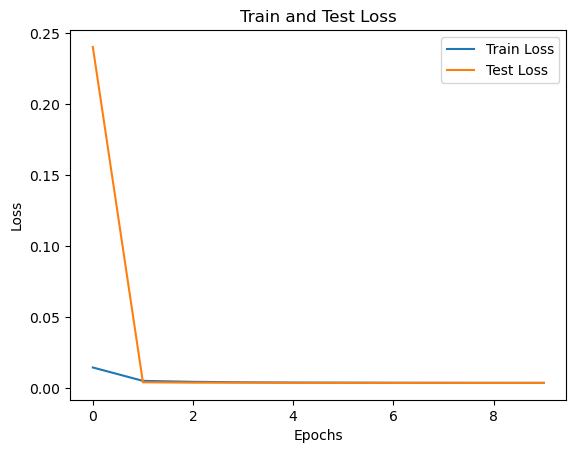

In [214]:
# plot both train and test loss
import matplotlib.pyplot as plt

def plot_loss(train_losses, test_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()
    plt.show()

plot_loss(train_loss_list, test_loss_list)

In [215]:
model.eval()
X_sample, y_true = next(iter(test_loader))
X_sample, y_true = X_sample.to(device), y_true.to(device)
y_pred = model(X_sample)

# mean of the predictions
pred_moments = []
for i in range(T):
    pred_moments.append(y_pred[:, i, :, :].mean(dim=0).cpu().detach().numpy())

# true moments using B^k
true_moments = compute_moments(B, T_max=T)


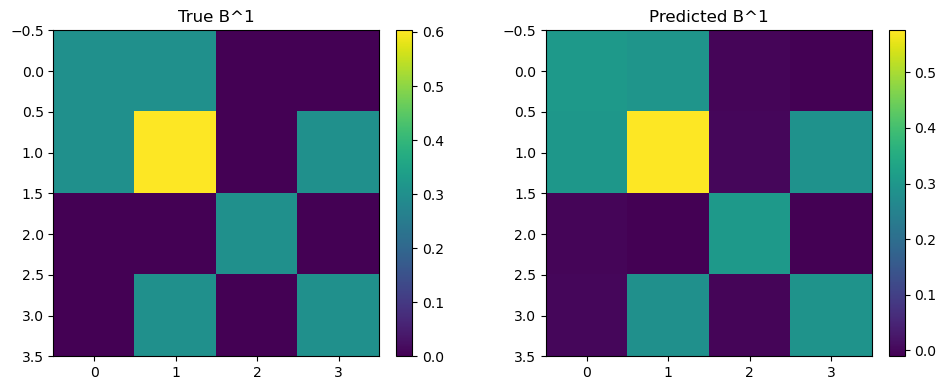

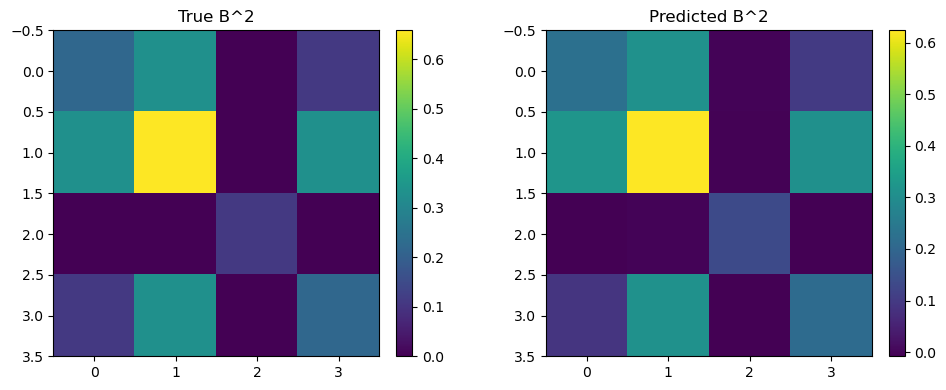

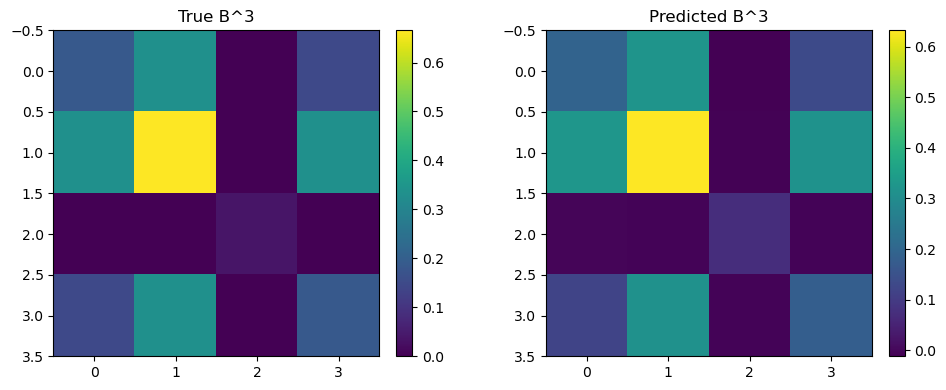

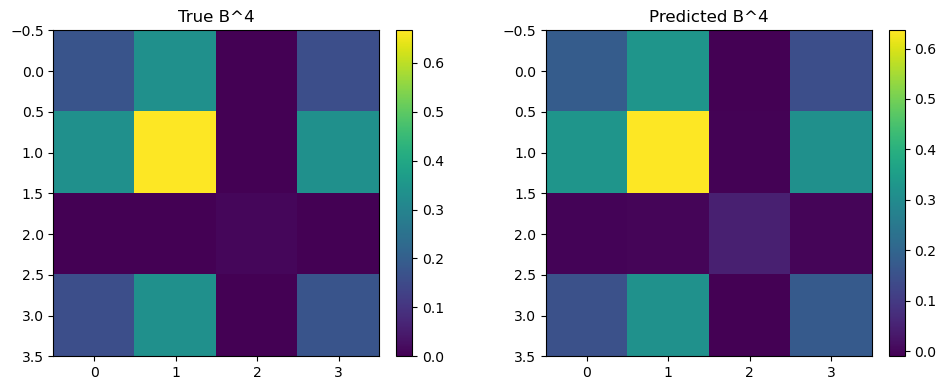

In [216]:
import matplotlib.pyplot as plt

for k in range(T):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    im0 = axes[0].imshow(true_moments[k], cmap='viridis')
    axes[0].set_title(f'True B^{k+1}')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(pred_moments[k], cmap='viridis')
    axes[1].set_title(f'Predicted B^{k+1}')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


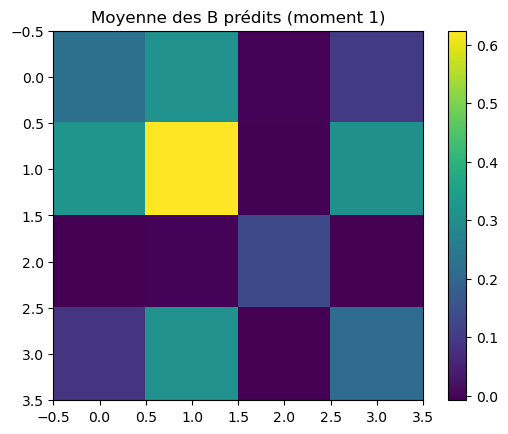

In [217]:
# Supposons que y_pred ∈ ℝ^{N, T, T, T}
# On extrait les B = y_pred[:, 0, :, :]  (le premier moment)
B_pred = y_pred[:, 1, :, :]  # (N, T, T)

# Moyenne sur le batch
B_mean = B_pred.mean(dim=0)  # (T, T)

# Si tu veux afficher la matrice ou la convertir en numpy
import matplotlib.pyplot as plt

plt.imshow(B_mean.cpu().detach().numpy(), cmap='viridis')
plt.title('Moyenne des B prédits (moment 1)')
plt.colorbar()
plt.show()


In [218]:
B_mean

tensor([[ 0.2262,  0.3128, -0.0028,  0.0984],
        [ 0.3202,  0.6238, -0.0036,  0.3095],
        [-0.0081, -0.0013,  0.1328, -0.0064],
        [ 0.0886,  0.3113, -0.0080,  0.2127]], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [219]:
B

array([[1, 1, 0, 0],
       [1, 2, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 1]])